In [1]:
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import torch
import os
import json

In [2]:
expression = ad.read_h5ad("/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_200k_clean/K562/cells.h5ad", backed="r")
# expression = ad.read_h5ad("/hpc/archives/group.califano/replogle.h5ad", backed="r")
expression

AnnData object with n_obs × n_vars = 199954 × 7948 backed at '/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_200k_clean/K562/cells.h5ad'
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample_id', 'cluster'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cluster', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
perturbation_var = "gene_id"
# Below, any cells where perturbation_var is 'nan' - or the perturbed gene is not in the column genes - are discarded
gene_ids = expression.obs[perturbation_var] # Get the perturbed gene ids
control_mask = (gene_ids == "non-targeting") # Mask accounting for cells with non-targeting intervention
perturbed_mask = gene_ids.isin(expression.var.index).to_numpy() # Mask accounting for cells with perturbed genes that are included in our dataset

control_cells = expression[control_mask] # Get the control cells from the perturbation dataset
perturbed_cells = expression[perturbed_mask] # Get the perturbed cells from the perturbation dataset

print("Number of control cells:", control_cells.shape[0])
print("Number of perturbed cells:", perturbed_cells.shape[0])

Number of control cells: 7454
Number of perturbed cells: 147797


#### Get the average control gene expression for K562

In [4]:
ctrl_array = control_cells.to_memory().X.toarray()
ctrl_array.shape

(7454, 7948)

In [5]:
ctrl_mean = np.mean(ctrl_array, axis=0)
ctrl_mean.shape

(7948,)

#### Get the average perturbed gene expression for K562

In [6]:
# Convert to pandas DataFrames
perturbation_ENSGs = perturbed_cells.obs[perturbation_var].reset_index(drop=True) # Series object of perturbation for each cell (after filtering cells)
perturbation_ENSGs.unique().shape

(7645,)

In [7]:
mean_perturbed = {}
for prt in tqdm(perturbation_ENSGs.unique()):
    mask = (expression.obs["gene_id"] == prt)
    prt_array = expression[mask, :].to_memory().X.toarray()
    prt_mean = np.mean(prt_array, axis=0)
    mean_perturbed[prt] = prt_mean

  0%|          | 0/7645 [00:00<?, ?it/s]

  0%|          | 17/7645 [00:11<1:26:29,  1.47it/s]


KeyboardInterrupt: 

#### Iterate and find the lowest L2 norm

In [ ]:
effect = {}
for prt in tqdm(mean_perturbed.keys()):
    effect_size = np.linalg.norm(mean_perturbed[prt] - ctrl_mean)
    effect[prt] = float(effect_size)

100%|██████████| 16/16 [00:00<00:00, 69327.34it/s]


In [ ]:
with open("/hpc/projects/group.califano/full_effects_dict.json", "w") as f:
    json.dump(effect, f, indent=4)

#### Get the biggest effect size genes

In [8]:
with open("/hpc/projects/group.califano/full_effects.json", "r") as f:
    effect = json.load(f)
    
effect = pd.Series(effect).sort_values(ascending=False)
effect

ENSG00000115541    452.374146
ENSG00000099821    447.686096
ENSG00000164758    443.744232
ENSG00000153879    434.924774
ENSG00000138346    424.223053
                      ...    
ENSG00000167460      7.839399
ENSG00000146112      7.727196
ENSG00000162231      6.682524
ENSG00000213015      6.540812
ENSG00000169756      6.536252
Length: 7683, dtype: float64

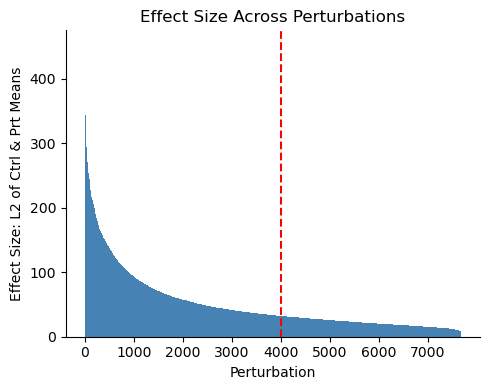

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example Series (replace with your Series)
your_series = effect

# Sort and re-index
sorted_series = your_series.sort_values(ascending=False).reset_index(drop=True)
n = len(sorted_series)

# Create the plot
fig, ax = plt.subplots(figsize=(5, 4))

# Vertical bars
ax.bar(
    x=np.arange(n),
    height=sorted_series.values,
    width=1.0,
    color="steelblue",
)

# Red vertical line at x = 4000
ax.axvline(x=4000, color='red', linestyle='--', linewidth=1.5)

# Only label every 1000th sample on the x-axis
step = 1000
xticks = np.arange(0, n, step)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)

# Cleanup
ax.set_xlabel("Perturbation")
ax.set_ylabel("Effect Size: L2 of Ctrl & Prt Means")
ax.set_title("Effect Size Across Perturbations")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [37]:
effect[:4000]

ENSG00000115541    452.374146
ENSG00000099821    447.686096
ENSG00000164758    443.744232
ENSG00000153879    434.924774
ENSG00000138346    424.223053
                      ...    
ENSG00000139832     32.209206
ENSG00000166025     32.191921
ENSG00000159445     32.188953
ENSG00000085998     32.188839
ENSG00000140264     32.175652
Length: 4000, dtype: float64

In [63]:
selected_genes = list(set(effect[:4000].index) & set(expression.var.index)) # Get intersection of sets
print(len(selected_genes))

selected_cells_mask = expression.obs["gene_id"].isin(selected_genes + ["non-targeting"])
print(selected_cells_mask.sum())

3998
70379


In [66]:
expression[selected_cells_mask, selected_genes]

View of AnnData object with n_obs × n_vars = 70379 × 3998 backed at '/hpc/projects/group.califano/GLM/data/_replogle/data/replogle_200k_clean/K562/cells.h5ad'
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample_id', 'cluster'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cluster', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'